### step1 : 구글의 파이썬 API 인터페이스 모듈을 아래와 설치

```
$ pip install --upgrade google-api-python-client
$ pip install google-cloud-vision
```

### step2 : Google Cloud Vision API 사용
브라우저에서 다운로드한 인증키는 `my_google_api_key.json`이라는 파일명으로 변경

### step3 API 사용 테스트

In [3]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [4]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/chatbot-app-277104-fac47ea59157.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/handwriting.jpg'   

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

-rw-r--r-- 1 root root 2325 Sep 13 16:08 /aiffel/aiffel/ocr_python/chatbot-app-277104-fac47ea59157.json
Texts:

"Loan Number
20134613.
Today date's
Customer ID → sog475127
2-28-2019
572437-72, 75,000.00
Amounit
Account Nomber -→ 193506555
Nane
RomANO UNIT 100 LC
"

"Loan"

"Number"

"20134613."

"Today"

"date's"

"Customer"

"ID"

"→"

"sog475127"

"2-28-2019"

"572437-72,"

"75,000.00"

"Amounit"

"Account"

"Nomber"

"-→"

"193506555"

"Nane"

"RomANO"

"UNIT"

"100"

"LC"
bounds: (1541,986),(1715,966),(1722,1029),(1548,1049)


## 어떤 과정으로 읽을까요?
구글 API에서는 문자의 영역을 사각형으로 표현하고 우측에 Block과 Paragraph로 구분해서 인식 결과를 나타내고 있었다.  
구글 API가 이미지에 박스를 친 다음 박스별 텍스트의 내용을 알려준 것처럼, 문자 모델은 보통 두 단계로 이뤄진다.
1. Text Detection(문자검출) :  먼저 입력받은 사진 속에서 문자의 위치를 찾아낸다.
2. Text Recognition(문자인식) : 찾은 문자 영역으로부터 문자를 읽어내는 것

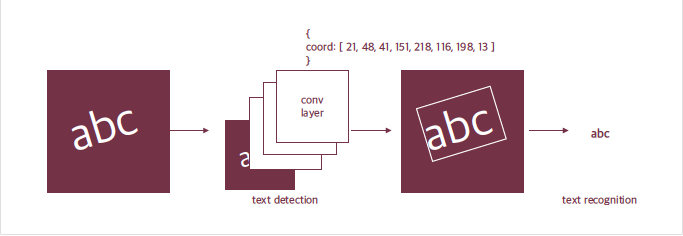  
[출처: https://brunch.co.kr/@kakao-it/318]

문자의 영역을 표현하는 방법으로 사각형의 네 꼭짓점 좌표를 알려 주는 방법을 제시하고 있다.  
밑에는 이런 방법을 연구한 많은 논문들 중 하나이다.
https://www.mdpi.com/2079-9292/9/1/117/pdf

## 딥러닝 문자인식의 시작
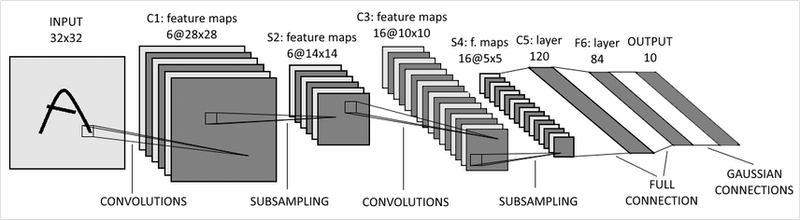  
[출처: http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf]

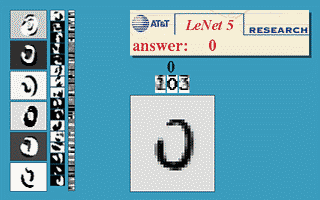  
[출처: http://yann.lecun.com/exdb/lenet/stroke-width.html]


(Stroke Width Invariance)[http://yann.lecun.com/exdb/lenet/stroke-width.html]  
(Robustness to Noise)[http://yann.lecun.com/exdb/lenet/noisy-2.html]  


## 사진 속 문자 찾아내기 - detection
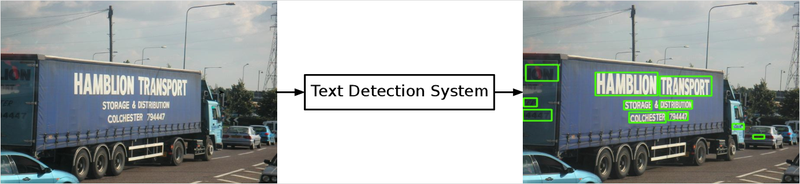  
[출처: https://www.semanticscholar.org/paper/End-To-End-Text-Detection-Using-Deep-Learning-Ibrahim/6d8584a900bd77afec55921c2d2d1cb6f1244b25/figure/0]

사진 속 문자를 찾아내는 최근의 딥러닝 모델은 일반적인 Object Detection(객체 인식) 방법으로 접근한다.  
딥러닝 기반 객체 검출 방법에는 Regression(회귀) 방식이나 Segmentation(세그멘테이션) 방식이 있다.  
- Regression은 기준으로 하는 박스 대비 문자의 박스가 얼마나 차이가 나는지를 학습한다. 
- Segmentation은 픽셀 단위로 해당 픽셀이 문자를 표현하는지를 분류하는 문제(pixel-wise classification)라고 볼 수 있다.

[딥러닝을 활용한 객체 탐지 알고리즘 이해하기](https://blogs.sas.com/content/saskorea/2018/12/21/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84-%ED%99%9C%EC%9A%A9%ED%95%9C-%EA%B0%9D%EC%B2%B4-%ED%83%90%EC%A7%80-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0/)

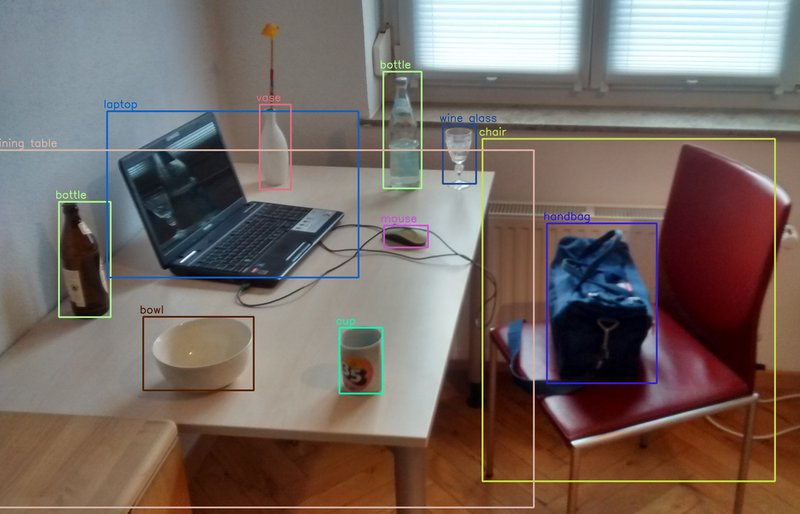  
[출처 : https://it.wikipedia.org/wiki/File:Detected-with-YOLO--Schreibtisch-mit-Objekten.jpg]



## 사진 속 문자 읽어내기 - recognition
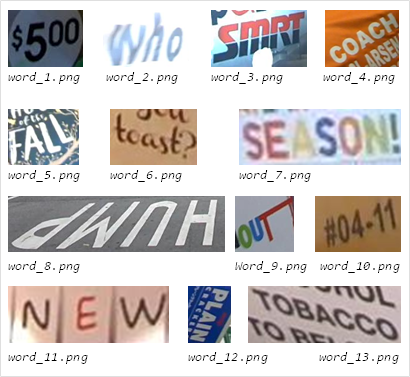  
[출처: ICDAR (https://rrc.cvc.uab.es/?ch=4&com=tasks)]

문자 인식은 사진 속에서 문자를 검출해내는 검출 모델이 영역을 잘라서 주면 그 영역에 어떤 글자가 포함되어 있는지 읽어내는 과정이다.  
이 과정은 이미지 문제보다는 자연어 처리에서 많은 영감을 받았으며, 이미지 내의 문자 인식 모델의 기본적인 방법 중 하나가 바로 CNN과 RNN을 결합한 CRNN 모델이다. 이미지 내의 텍스트와 연관된 특징을 CNN을 통해 추출한 후에 스텝 단위의 문자 정보를 RNN으로 인식하는 것이다.

[네이버 데뷰 2018, 이활석님의 CRAFT 모델소개와 연구 경험](https://tv.naver.com/v/4578167)  
[Terry TaeWoong Um님의 사진 속 글자 읽기, OCR (Optical character recognition)](https://www.youtube.com/watch?v=ckRFBl_XWFg)

## keras-ocr 써보기
`keras-ocr`은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해준다.  
공식 문서에도 나와 있듯, 검출 모델로는 네이버 데뷰 2018 영상에서 소개한 CRAFT(Character Region Awareness for Text Detection)를 사용하고, 인식 모델로는 앞에서 설명한 CRNN을 사용한다.

keras-ocr 버전을 클라우드 쉘에서 확인해보자.
```
$ pip list | grep keras-ocr
```

필요한 라이브러리인 `keras_ocr` 과 인식 결과의 시각화를 위한 `matplotlib.pyplot` 를 불러온다. 
`keras_ocr.pipeline.Pipeline()`는 인식을 위한 파이프라인을 생성하는데, 
이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러오게 된다. 
검출기와 인식기를 위한 가중치 하나씩을 불러오자.

[keras ocr 공식문서](https://keras-ocr.readthedocs.io/en/latest/index.html)

In [5]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


만들어둔 파이프라인의 `recognize()` 에 이미지를 몇 개 넣어준다.  
https://unsplash.com/s/photos/text 의 링크이다.

In [6]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

인식된 결과를 pyplot으로 시각화를 해부자.

내부적으로 `recognize()` 는 검출기와 인식기를 두고,   
검출기로 바운딩 박스(bounding box, 문자가 있는 영역을 표시한 정보)를 검출한 뒤,  
인식기가 각 박스로부터 문자를 인식하는 과정을 거친다.

[keras-ocr 파이프라인](https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/pipeline.py)

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


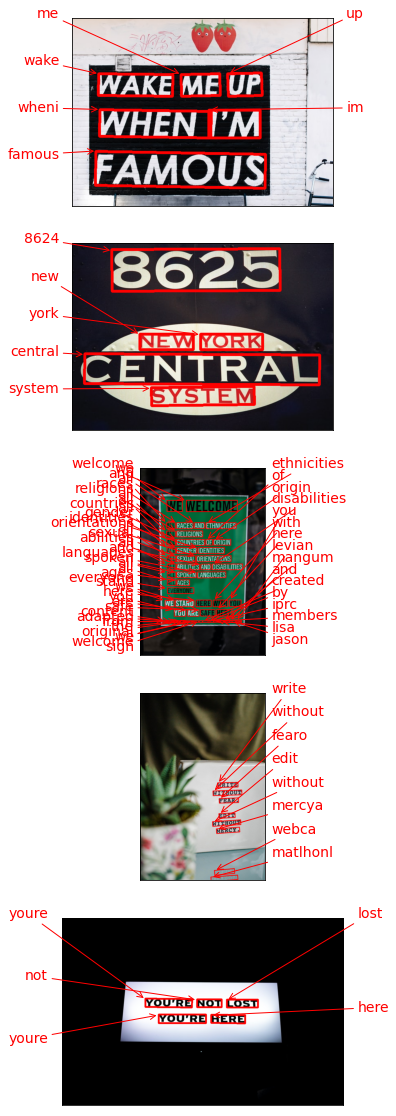

In [7]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

하지만 한국어를 훈련이 되어있지 않은 모델이다.  
[korean language support 이슈](https://github.com/faustomorales/keras-ocr/issues/101)

## 테서랙트 써보기
테서랙트(Tesseract) 라이브러리로 이미지에서 문자를 인식해 보겠다.  
테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재는 버전 4와 Tesseract.js등으로 확장되는 등 많은 곳에서 사용되고 있다.  
버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116 개 국어를 지원하고 있다.

### 1) 테서랙트 설치하기
클라우드 쉘에서 아래 코드를 사용해 테서랙트 관련 패키지들을 설치해보자.
```
$ sudo apt install tesseract-ocr
$ sudo apt install libtesseract-dev
```

### 2) 테서랙트 파이썬 wrapper 설치하기
Pytesseract는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리(wrapper library)이다.   
파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해준다.  
[pytesseract](https://pypi.org/project/pytesseract/)  
[wikipedia : wrapper library](https://ko.wikipedia.org/wiki/%EB%9E%98%ED%8D%BC_%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC)

```
$ pip list | grep pytesseract
```

만약 설치가 안 되어 있다면 아래 명령어를 이용해 설치하자.
```
$ pip install pytesseract
```

### 3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)
테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있다.  
OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저 해 보자.

In [12]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/handwriting_korean.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png
/aiffel/aiffel/ocr_python/0014.png
/aiffel/aiffel/ocr_python/0015.png
/aiffel/aiffel/ocr_python/0016.png
/aiffel/aiffel/ocr_python/0017.png
/aiffel/aiffel/ocr_python/0018.png
/aiffel/aiffel/ocr_python/0019.png
/aiffel/aiffel/ocr_python/0020.png
/aiffel/aiffel/ocr_python/0021.png
/aiffel/aiffel/ocr_python/0022.png
/aiffel/aiffel/ocr_python/0023.png
/aiffel/aiffel/ocr_python/0024.png
/aiffel/aiffel/ocr_python/0025.png
/aiffel/aiffel/ocr_python/0026.png
/aiffel/aiffel/ocr_python/0027.png
/aiffel/aiffel/ocr_p

위에서 구현한 `crop_word_regions()` 함수는 여러분이 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수이다.

기본적으로 `pytesseract.image_to_data()` 를 사용한다. 파이썬에서 편하게 사용하기 위해서 pytesseract 의 Output 을 사용해서 결괏값의 형식을 딕셔너리(DICT) 형식으로 설정해 주게 된다. 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가진다. 
바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 cropped_image_path_list에 담아 리턴했다.

🙌👀(주의) 위 코드에서 lang='kor' 로 바꾸면 에러가 발생하면, 테서랙트의 언어팩을 설치해야 정상 동작하게 된다.

```
$ sudo apt install tesseract-ocr-kor
```

### 4) 테서랙트로 잘린 이미지에서 단어 인식하기
이제 문자 인식을 해 볼 차례이다.  
검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 image_to_string()를 사용하게 된다.

인식된 결과와 실제이미지를 비교해보자.

In [14]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

서언

|             들

낭

그

그

4

로

초

7 건

나

로 ㅋ

로 ㅋ

홈

쫓

속

으룬

|             들

\그 난

|

-

가,

오자

는 오

【

눔

는

^

중

들

어기

조개

|

2\두

고

나 ~

^“ 개

+ 40

ㄴ

0

느딘

나

즈어

ㅣ

^

2

0ㅜ7

마

\ㄴ+

남겨선

약속

너드 지

노

조너

오자

나은

섰

응

본

고


1

있어

즈4

| 꽤 노

고

]

ㄴㄴ

~

니2 04

혀

'

ㅋ.

1

고

나

6“

니드가

는 ~

료

0

타거

| 다시

거

섯

반

개 운

^ 가

-

에 나

분

톡스

잇 개

3)

오체

~


6

(ㅅㅅ

|             들

나

|             들

해

+

0 …ㄴ

^

」ｌ0\

두

휴

ㅣ

1

거우

건


간은

-{

의

중 01

락

삿

중

수

~

|

74

2003

Done
